#### Notes on current version:
**To Try**:
- [Cayley parameterization](https://planetmath.org/cayleysparameterizationoforthogonalmatrices) of $SU_d$ (since this is really all we need)...*will it be more stable than Lie's parameterization?* Note: it is a homeomorphism so this is great for UAP!
- SVD approach to pre-trainining 
  - (here for procrustes problem)[https://en.wikipedia.org/wiki/Orthogonal_Procrustes_problem]
  - [here for complexity](https://mathoverflow.net/questions/161252/what-is-the-time-complexity-of-truncated-svd)

# NEU (Reconfigurations Map and Related Functions)

### Basic Algorithm (NEU-OLS)

1. Perform Basic Algorithm (in this case OLS)
2. Map predictions to their graph; ie $x\mapsto (x,\hat{f}_{OLS}(x))$ where $\hat{f}_{OLS}$ is the least-squares regression function.

## Initializations:

In [1]:
# Deep Learning & ML
import tensorflow as tf
import tensorflow_probability as tfp
import keras as K
import keras.backend as Kb
from keras.layers import *

from keras.models import Model
from keras.models import Sequential
from keras import layers
from keras import utils as np_utils
from scipy import linalg as scila

from tensorflow.keras.initializers import RandomUniform
from tensorflow.keras.constraints import NonNeg



# Linear Regression
from sklearn.linear_model import LinearRegression

# General
import numpy as np
import time

# Alerts
import os as beepsnd

# Others
import math

# General Outputs
print('TensorFlow:', tf.__version__)

Using TensorFlow backend.


TensorFlow: 2.1.0


In [2]:
N_Reconfigurations = 5
d = 1 # Dimension of X
D = 1 # Dimension of Y


# Data Meta-Parameters
noise_level = 0.1
uncertainty_level= 0.5

# Training meta-parameters
Pre_Epochs = 10
Full_Epochs = 200

# # Height Per Reconfiguration
Height_factor_Per_reconfig = d+D
Initial_Depth = 20


# Number of Datapoints
N_data = 10**3
# Unknown Function
def unknown_f(x):
    return np.sin(2*x) #+ (x % 2)

# Generate Data
%run Data_Generator.ipynb

<Figure size 640x480 with 1 Axes>

#### Prepare data for NEU

In [3]:
# Reshape Data Into Compatible Shape
data_x = np.array(data_x).reshape(-1,d)
data_y = np.array(data_y)
# Perform OLS Regression
linear_model = LinearRegression()
reg = linear_model.fit(data_x, data_y)
model_pred_y = linear_model.predict(data_x)
# Map to Graph
data_NEU = np.concatenate((data_x,model_pred_y.reshape(-1,D)),1)
NEU_targets_full  = np.concatenate((data_x,data_y.reshape(-1,D)),1)
NEU_targets  = data_y.reshape(-1,D)

### Helper Function(s)

In [4]:
def above_percentile(x, p): #assuming the input is flattened: (n,)

    samples = Kb.cast(Kb.shape(x)[0], Kb.floatx()) #batch size
    p =  (100. - p)/100.  #100% will return 0 elements, 0% will return all elements

    #samples to get:
        #you can choose tf.math.ceil above, it depends on whether you want to
        #include or exclude one element. Suppose you you want 33% top,
        #but it's only possible to get exactly 30% or 40% top:
        #floor will get 30% top and ceil will get 40% top.
        #(exact matches included in both cases)

    #selected samples
    values, indices = tf.math.top_k(x, samples)

    return values

# def Robust_MSE(p):
#     def loss(y_true, y_predicted):
#         ses = Kb.pow(y_true-y_predicted,2)
#         above = above_percentile(Kb.flatten(ses), p)
#         return Kb.mean(above)
#     return loss
def Robust_MSE(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)

    y_true.shape = (y_true.shape[0], 1)
    y_pred.shape = (y_pred.shape[0], 1)

    # Compute Exponential Utility
    loss_out = np.abs((y_true - y_pred))
    loss_out = np.math.exp(-p*loss_out)
    loss_out = np.mean(loss_out)
    return loss_out

### Build Reconfiguration Unit
*Lie Version:* $$
x \mapsto \exp\left(
%\psi(a\|x\|+b)
\operatorname{Skew}_d\left(
    F(\|x\|)
\right)
\right) x.
$$

*Cayley version:*
$$
\begin{aligned}
x \mapsto & \left[(I_d + A(x))(I- A(x))^{-1}\right]x
\\
A(x)\triangleq &%\psi(a\|x\|+b)
\operatorname{Skew}_d\left(
    F(\|x\|)\right)
\end{aligned}
$$

tf.linalg.inv

In [5]:
class Reconfiguration_unit(tf.keras.layers.Layer):
    
    def __init__(self, units=16, input_dim=32):
        super(Reconfiguration_unit, self).__init__()
        self.units = units
    
    def build(self, input_shape):
        #------------------------------------------------------------------------------------#
        # Center
        #------------------------------------------------------------------------------------#
        self.location = self.add_weight(name='location',
                                    shape=(self.units,),
                                    initializer='random_normal',
                                    trainable=True)
        
        #------------------------------------------------------------------------------------#
        # Bump Function
        #------------------------------------------------------------------------------------#
#         self.sigma = self.add_weight(name='bump_threshfold',
#                                         shape=[1],
#                                         initializer=RandomUniform(minval=.5, maxval=1),
#                                         trainable=True,
#                                         constraint=tf.keras.constraints.NonNeg())
#         self.a = self.add_weight(name='bump_scale',
#                                         shape=[1],
#                                         initializer='ones',
#                                         trainable=True)
#         self.b = self.add_weight(name='bump_location',
#                                         shape=[1],
#                                         initializer='zeros',
#                                         trainable=True)

        #------------------------------------------------------------------------------------#
        # Tangential Map
        #------------------------------------------------------------------------------------#
        self.Id = self.add_weight(name='Identity_Matrix',
                                   shape=(input_shape[-1],input_shape[-1]),
                                   initializer='identity',
                                   trainable=False)
        self.Tw1 = self.add_weight(name='Tangential_Weights_1 ',
                                   shape=(input_shape[-1],input_shape[-1]),
                                   initializer='GlorotUniform',
                                   trainable=True)
        
        self.Tw2 = self.add_weight(name='Tangential_Weights_2 ',shape=(input_shape[-1],input_shape[-1]),initializer='GlorotUniform',trainable=True)

        self.Tb1 = self.add_weight(name='Tangential_basies_1',shape=(input_shape[-1],input_shape[-1]),initializer='GlorotUniform',trainable=True)
        self.num_stab_param = self.add_weight(name='matrix_exponential_stabilizer',shape=[1],initializer=RandomUniform(minval=0.0, maxval=0.01),trainable=True,constraint=tf.keras.constraints.NonNeg())
        
        # Wrap things up!
        super().build(input_shape)

    def bump_function(self, x):
        return tf.math.exp(-self.sigma / (self.sigma - x))

        
    def call(self, input):
        #------------------------------------------------------------------------------------#
        # Initializations
        #------------------------------------------------------------------------------------#
        norm_inputs = tf.norm(input) #WLOG if norm is squared!
        
        #------------------------------------------------------------------------------------#
        # Bump Function
        #------------------------------------------------------------------------------------#
#         bump_input = self.a *norm_inputs + self.b
#         greater = tf.math.greater(bump_input, -self.sigma)
#         less = tf.math.less(bump_input, self.sigma)
#         condition = tf.logical_and(greater, less)

#         output_bump = tf.where(
#             condition, 
#             self.bump_function(bump_input),
#             0.0)
        
        
        
        
        #------------------------------------------------------------------------------------#
        # Tangential Map
        #------------------------------------------------------------------------------------#
        # Build Radial, Tangent-Space Valued Function, i.e.: C(R^d,so_d) st. f(x)=f(y) if |x|=|y|
        
        
        # Build Tangential Feed-Forward Network (Bonus)
        #-----------------------------------------------#
        tangential_ffNN = norm_inputs*self.Tw1
        tangential_ffNN = tangential_ffNN + self.Tb1
        tangential_ffNN = tf.nn.relu(tangential_ffNN)  
        tangential_ffNN = tf.matmul(tangential_ffNN, self.Tw2) 
    
        # Map to Rotation-Matrix-Valued Function #
        #----------------------------------------#
        tangential_ffNN = (tf.transpose(tangential_ffNN) - tangential_ffNN) 
#         tangential_ffNN = output_bump*tangential_ffNN
        tangential_ffNN = tangential_ffNN + self.num_stab_param*tf.linalg.diag(tf.ones(d+D))
    
        # Lie Parameterization (Numerically Unstable)
        #tangential_ffNN = tf.linalg.expm(tangential_ffNN)
        # Cayley Transformation (Stable)
        tangential_ffNN = tf.linalg.matmul((self.Id + tangential_ffNN),tf.linalg.inv(self.Id - tangential_ffNN))
        
        # Exponentiation and Action
        #----------------------------#
        x_out = tf.linalg.matvec(tangential_ffNN,(input-self.location)) + self.location
        
        # Return Output
        return x_out

### Projection Layer

In [6]:
projection_layer = tf.keras.layers.Lambda(lambda x: x[:, -D:])

# Build

In [7]:
# define and fit the base model
def get_base_model(trainx, trainy, Pre_Epochs_in, depth):
    # Define Model
    #----------------#
    # Initialize
    input_layer = tf.keras.Input(shape=[d+D])
    # Apply Reconfiguration Unit
    output_layer  = Reconfiguration_unit(d+D)(input_layer)
    
    if depth > 0:
        output_layer  = Reconfiguration_unit(d+D)(output_layer)
    
    # Output
#     output_layer = projection_layer(output_layer)
    reconfiguration_basic = tf.keras.Model(inputs=[input_layer], outputs=[output_layer])
    
    # Compile Model
    #----------------#
    # Define Optimizer
    optimizer_on = tf.keras.optimizers.SGD(learning_rate=10**(-2), momentum=0.01, nesterov=True)
    # Compile
    reconfiguration_basic.compile(loss = 'mae',
                    optimizer = optimizer_on,
                    metrics = ['mse'])
    
    # Fit Model
    #----------------#
    reconfiguration_basic.fit(trainx, trainy, epochs=Pre_Epochs_in, verbose=0)
        
    # Return Output
    return reconfiguration_basic

#### Greedy Initialization of Subsequent Units
Build reconfiguration and pre-train using greedy approach.

In [8]:
def add_reconfiguration_unit_greedily(model, trainx, trainy, Pre_Epochs_in):

    # Dissasemble Network
    layers = [l for l in model.layers]

    # Define new reconfiguration unit to be added
    output_layer_new  = Reconfiguration_unit(d+D)(layers[len(layers)-2].output)

    # Output Layer
#     output_layer_new = projection_layer(output_layer_new)

    for i in range(len(layers)):
        layers[i].trainable = False


    # build model
    new_model = tf.keras.Model(inputs=[layers[0].input], outputs=output_layer_new)
    #new_model.summary()


    # Compile new Model
    #-------------------#
    # Define Optimizer
    optimizer_on = tf.keras.optimizers.SGD(learning_rate=10**(-2), momentum=0.01, nesterov=True)
    # Compile Model
    new_model.compile(loss = 'mae',
                    optimizer = optimizer_on,
                    metrics = ['mse'])

    # Fit Model
    #----------------#
    new_model.fit(trainx, trainy, epochs=Pre_Epochs_in, verbose=0)

    # Return Output
    return new_model

#### Train and Compile (entire) reconfiguration using greedy-initializations past from previous helper functions.
Train reconfiguration together (initialized by greedy) layer-wise initializations.

In [9]:
def build_reconfiguration(model_greedy_initialized, trainx, trainy, Full_Epochs_in):

    # Dissasemble Network
    layers = [l for l in model_greedy_initialized.layers]

    # Define new reconfiguration unit to be added
    output_layer_new  = Reconfiguration_unit(d+D)(layers[len(layers)-2].output)

    # Output Layer
#     output_layer_new = projection_layer(output_layer_new)

    for i in range(len(layers)):
        layers[i].trainable = True


    # build model
    reconfiguration = tf.keras.Model(inputs=[layers[0].input], outputs=output_layer_new)
    #new_model.summary()



    # Compile new Model
    #-------------------#
    # Define Optimizer
    optimizer_on = tf.keras.optimizers.SGD(learning_rate=10**(-5), momentum=0.01, nesterov=True)

    # Compile Model
    reconfiguration.compile(loss = 'mae',
                    optimizer = optimizer_on,
                    metrics = ['mse'])

    # Fit Model
    #----------------#
    reconfiguration.fit(trainx, trainy, epochs=Full_Epochs_in, verbose=1)

    # Return Output
    return reconfiguration

# Train the model

In [10]:
# Base Model
model = get_base_model(data_NEU,NEU_targets,10,Initial_Depth)

# Greedy Initialization
NEU_OLS_Greedy_init = model
for i in range(N_Reconfigurations):
    # Update Model
    NEU_OLS_Greedy_init_temp = add_reconfiguration_unit_greedily(NEU_OLS_Greedy_init,
                                                                 data_NEU,
                                                                 NEU_targets_full,
                                                                 Pre_Epochs)
    
    # Check for Blowup
    if math.isnan(np.mean(NEU_OLS_Greedy_init.predict(data_NEU))):
        NEU_OLS_Greedy_init = NEU_OLS_Greedy_init
        break
    else: #Update Model if not explosion
        NEU_OLS_Greedy_init = NEU_OLS_Greedy_init_temp
    
    print(np.mean((NEU_OLS_Greedy_init.predict(data_NEU) - data_y)**2))
    
    # Update User on Status of Initialization
    print(((i+1)/N_Reconfigurations))

1.5631280686970244
0.2
1.6289967007819055
0.4
1.146575592410944
0.6
1.580342291558905
0.8
1.3956450782396042
1.0


## Train NEU-OLS

In [11]:
NEU_OLS = build_reconfiguration(NEU_OLS_Greedy_init,data_NEU,NEU_targets,Full_Epochs_in = Full_Epochs)

Train on 1000 samples
Epoch 1/200
1000/1000 [==============================] - 1s 557us/sample - loss: 0.7691 - mse: 0.7543
Epoch 2/200
1000/1000 [==============================] - 0s 55us/sample - loss: 0.7665 - mse: 0.7517
Epoch 3/200
1000/1000 [==============================] - 0s 59us/sample - loss: 0.7657 - mse: 0.7504
Epoch 4/200
1000/1000 [==============================] - 0s 60us/sample - loss: 0.7628 - mse: 0.7479
Epoch 5/200
1000/1000 [==============================] - 0s 56us/sample - loss: 0.7629 - mse: 0.7467
Epoch 6/200
1000/1000 [==============================] - 0s 60us/sample - loss: 0.7628 - mse: 0.7457
Epoch 7/200
1000/1000 [==============================] - 0s 65us/sample - loss: 0.7611 - mse: 0.7448
Epoch 8/200
1000/1000 [==============================] - 0s 73us/sample - loss: 0.7569 - mse: 0.7388
Epoch 9/200
1000/1000 [==============================] - 0s 58us/sample - loss: 0.7592 - mse: 0.7411
Epoch 10/200
1000/1000 [==============================] - 0s 86us/sa

1000/1000 [==============================] - 0s 58us/sample - loss: 0.6975 - mse: 0.6782
Epoch 82/200
1000/1000 [==============================] - 0s 52us/sample - loss: 0.6974 - mse: 0.6774
Epoch 83/200
1000/1000 [==============================] - 0s 51us/sample - loss: 0.6963 - mse: 0.6769
Epoch 84/200
1000/1000 [==============================] - 0s 50us/sample - loss: 0.6947 - mse: 0.6755
Epoch 85/200
1000/1000 [==============================] - 0s 56us/sample - loss: 0.6968 - mse: 0.6782
Epoch 86/200
1000/1000 [==============================] - 0s 48us/sample - loss: 0.6951 - mse: 0.6758
Epoch 87/200
1000/1000 [==============================] - 0s 52us/sample - loss: 0.6952 - mse: 0.6768
Epoch 88/200
1000/1000 [==============================] - 0s 57us/sample - loss: 0.6933 - mse: 0.6755
Epoch 89/200
1000/1000 [==============================] - 0s 65us/sample - loss: 0.6945 - mse: 0.6753
Epoch 90/200
1000/1000 [==============================] - 0s 63us/sample - loss: 0.6947 - mse: 

1000/1000 [==============================] - 0s 67us/sample - loss: 0.6749 - mse: 0.6587
Epoch 161/200
1000/1000 [==============================] - 0s 70us/sample - loss: 0.6756 - mse: 0.6601
Epoch 162/200
1000/1000 [==============================] - 0s 54us/sample - loss: 0.6745 - mse: 0.6596
Epoch 163/200
1000/1000 [==============================] - 0s 50us/sample - loss: 0.6736 - mse: 0.6586
Epoch 164/200
1000/1000 [==============================] - 0s 48us/sample - loss: 0.6729 - mse: 0.6582
Epoch 165/200
1000/1000 [==============================] - 0s 53us/sample - loss: 0.6744 - mse: 0.6595
Epoch 166/200
1000/1000 [==============================] - 0s 59us/sample - loss: 0.6740 - mse: 0.6585
Epoch 167/200
1000/1000 [==============================] - 0s 61us/sample - loss: 0.6743 - mse: 0.6591
Epoch 168/200
1000/1000 [==============================] - 0s 68us/sample - loss: 0.6733 - mse: 0.6576
Epoch 169/200
1000/1000 [==============================] - 0s 54us/sample - loss: 0.672

## Make Predictions

In [12]:
# # Predictions (for comparison: TEMP)
NEU_OLS_prediction = NEU_OLS.predict(data_NEU)
NEU_OLS_single_unit_prediction = model.predict(data_NEU)
NEU_OLS_greedy_initializations = NEU_OLS_Greedy_init.predict(data_NEU)

# Visualize Predictions

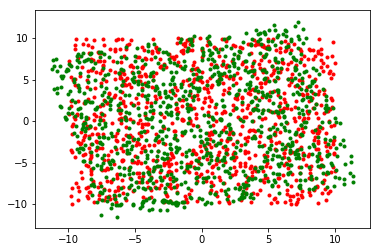

In [13]:
# Initial
visualization_grid = np.random.uniform(-10,10,[1000,2])
plt.scatter(visualization_grid[:,0],visualization_grid[:,1],color='red',marker = '.')
# Transformed
NEU_OLS_prediction_visualization = NEU_OLS.predict(visualization_grid)
plt.scatter(NEU_OLS_prediction_visualization[:,0],NEU_OLS_prediction_visualization[:,1],color='green',marker = '.')

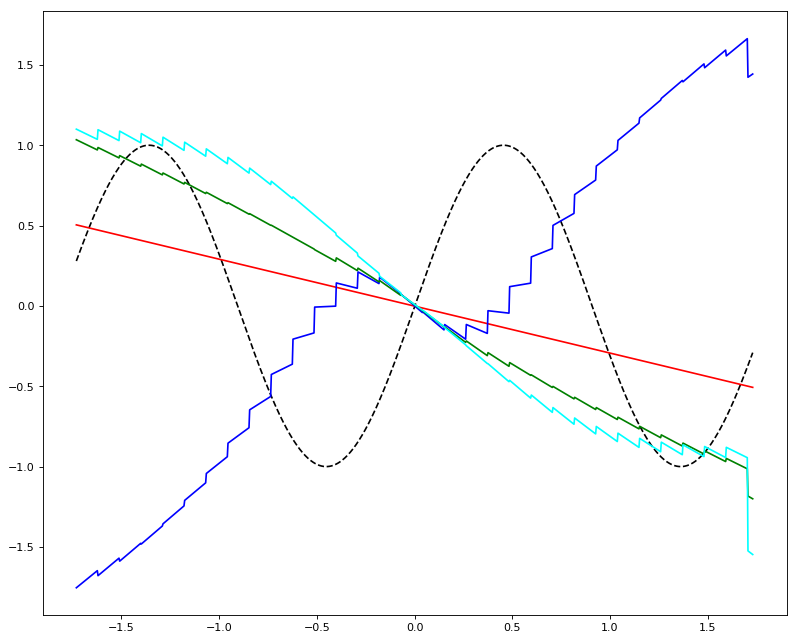

In [14]:
# Adjust Figure Details
plt.figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')

# Data Plot
plt.plot(data_x,true_y,color='k',label='true',linestyle='--')

# Plot Models
plt.plot(data_x,model_pred_y,color='r',label='OLS')
plt.plot(data_x,NEU_OLS_single_unit_prediction[:,1],color='b',label='NEU_Unit')
plt.plot(data_x,NEU_OLS_greedy_initializations[:,1],color='g',label='NEU_Greedy_Init')
plt.plot(data_x,NEU_OLS_prediction[:,1],color='Aqua',label='NEU-OLS')

 ---

#### The END